In [1]:
from copy import deepcopy

from scipy.spatial.distance import euclidean
from scipy.stats import zscore
from fastdtw import fastdtw
from scipy import signal
import pylab as plt
import numpy as np

from utils.misc import load_pkl


In [2]:
def find_lags(x, y):
    correlation = signal.correlate(x, y, mode="full")
    lags = signal.correlation_lags(x.size, y.size, mode="full")
    lag = lags[np.argmax(correlation)]
    return lag


def find_lags_npy(a, b):
    a = (a - np.mean(a)) / (np.std(a) * len(a))
    b = (b - np.mean(b)) / (np.std(b))
    c = np.correlate(a, b, 'full')
    return c.argmax()


def find_correlate(a, v, normalize=True):
    if normalize:
        a = (a - np.mean(a)) / (np.std(a) * len(a))
        v = (v - np.mean(v)) / np.std(v)
    return np.correlate(a, v)


def find_dist(x, y):
    x = zscore(x)
    y = zscore(y)
    distance, path = fastdtw(x, y, dist=euclidean)
    return distance


def make_stationary(x):
    x -= x.min(axis=0)
    x[1:] -= x[:-1]
    x = x[1:]
    return x


def compute_xcorr_map(rf):
    """"""
    xcorr_map = np.zeros((rf.shape[0], rf.shape[0])) - 1
    for i in range(rf.shape[0] - 1):

        # if i == 3:
        #     break
        # i += 3
        # print(i)
        for j in range(i + 1, rf.shape[0]):
            x, y = rf[i], rf[j]
            xcorr_map[i, j] = find_correlate(x, y)[0]

        # a = xcorr_map[i].copy()
        # l = []
        # thr = .75
        # for k, _ in enumerate(a):
        #     if a[k] > thr:
        #         l.append(rf[k].T)
        # # [plt.plot(l[k].T) for k in range(len(l))]
        # plt.plot(np.mean(l, axis=0))
        # plt.show()
        # print()
    return xcorr_map


def save_xcorr_maps():
    data = load_pkl()
    train = data['train']
    for pid in [0, 10, 20, 90, 100, 110]:
        print(train[pid])
        xcorr_map = compute_xcorr_map(train[pid].rf)
        # plt.imshow(xcorr_map, cmap='gray', vmin=-1, vmax=1)
        # plt.show()
        np.save(f'xcoor_maps/{pid}.npy', xcorr_map)

In [3]:
data = load_pkl()
train = data['test']

200
178


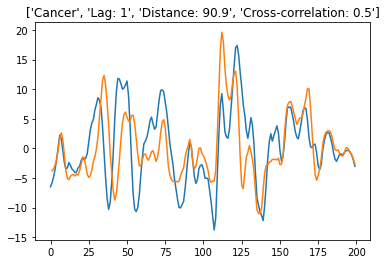

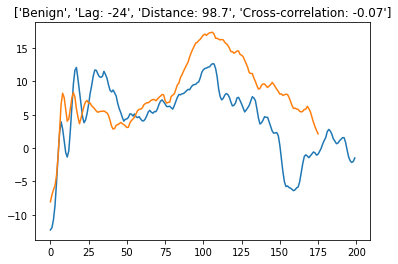

In [4]:
num_patients = 1
off_set = 0
n = 2

for i in range(num_patients * 2):
    idx = i + len(train) // 2 - num_patients if i >= num_patients else i
    idx += off_set
    core = train[idx]
    plt.figure(idx)
    # plt.plot((core.rf[:5].T - core.rf[:5].mean(axis=1).T)/ core.rf[:5].std(axis=1).T)
    x = deepcopy(core.rf[:n:n // 2].T)

#     x -= x.min(axis=0)
#     x[1:] -= x[:-1]
#     x = x[1:]

    x1 = x[:, 0]
    x2 = x[:, 1]
    x1 = signal.savgol_filter(x1, 7, 2)
    x2 = signal.savgol_filter(x2, 7, 2)

    print(find_lags_npy(x1, x2))

    # plt.plot(x[1:])
    # plt.imshow(core.rf[:20], cmap='gray')
    # continue

    lag = find_lags(x1, x2)
    dist = find_dist(x1, x2)
    plt.plot(x1)

    y = np.empty(x.shape[0])
    y[:] = np.nan
    if lag == 0:
        y[:] = x2
    elif lag < 0:
        y[:lag] = x2[-lag:]
    else:
        # plt.plot(x[lag:, 1])
        y[lag:] = x2[:-lag]
    plt.plot(y)

    plt.title(['Cancer' if core.cancer else 'Benign', 
               f'Lag: {lag}', 
               f'Distance: {np.round(dist, 1)}',
               f'Cross-correlation: {np.round(find_correlate(x1, x2)[0], 2)}'])
    # plt.axis('square')
plt.show()

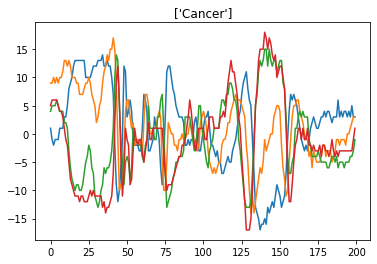

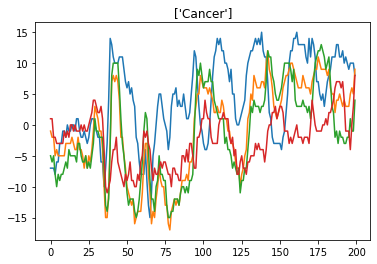

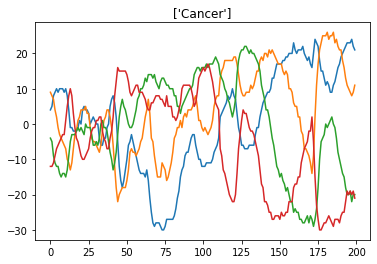

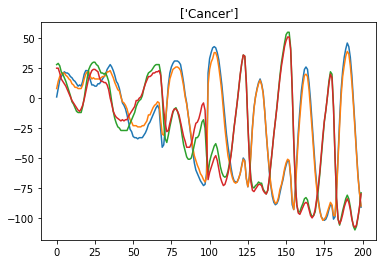

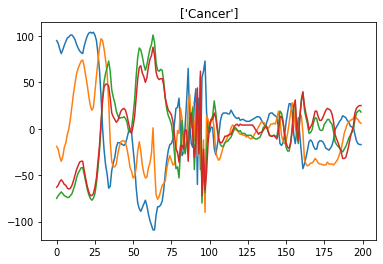

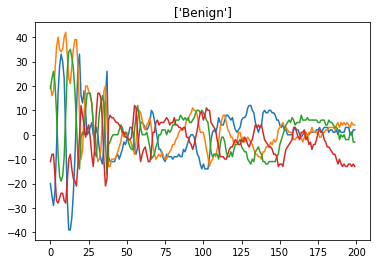

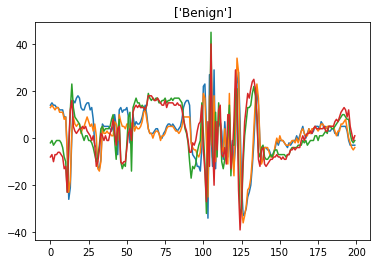

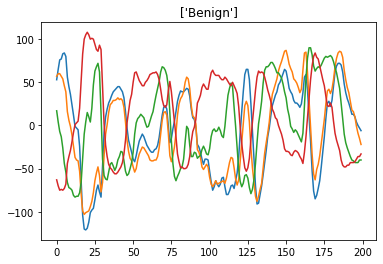

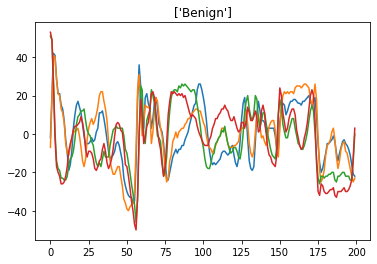

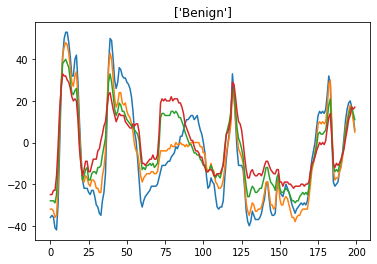

In [5]:
num_patients = 5
off_set = 20
n = 4
for i in range(num_patients * 2):
    idx = i + len(train) // 2 - num_patients if i >= num_patients else i
    idx += off_set
    core = train[idx]
    x = deepcopy(core.rf[:n].T)
    plt.figure(idx)
    plt.plot(x)
    plt.title(['Cancer' if core.cancer else 'Benign'])

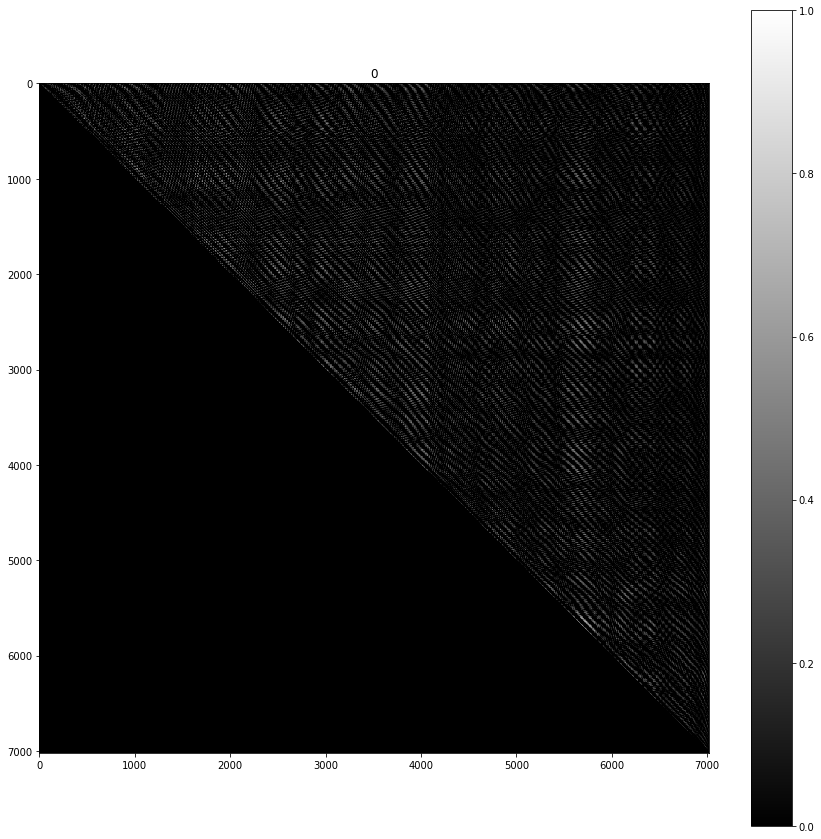

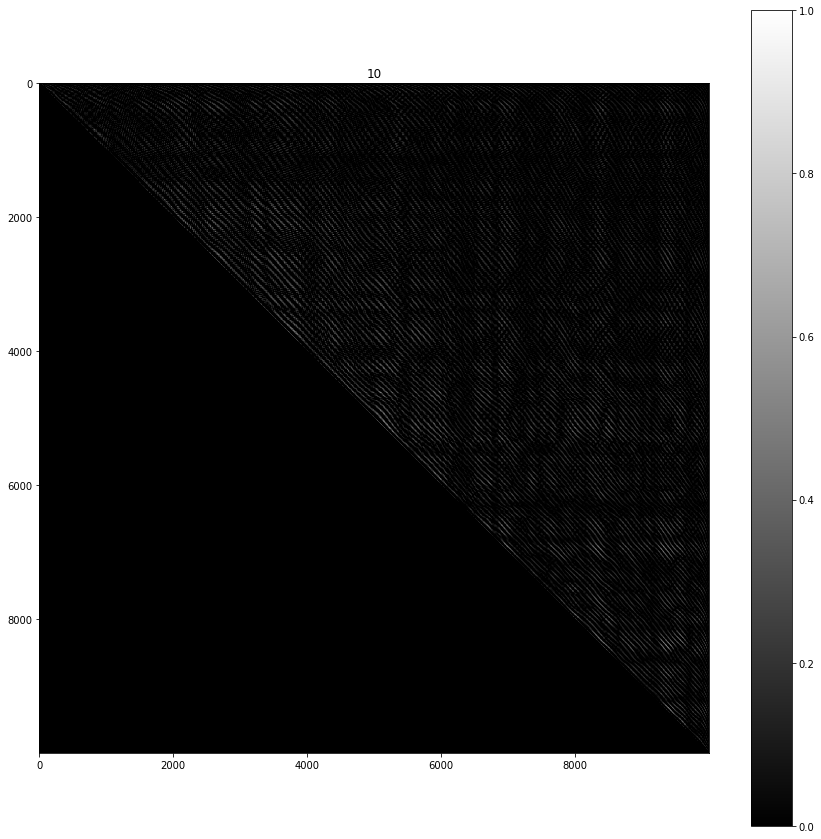

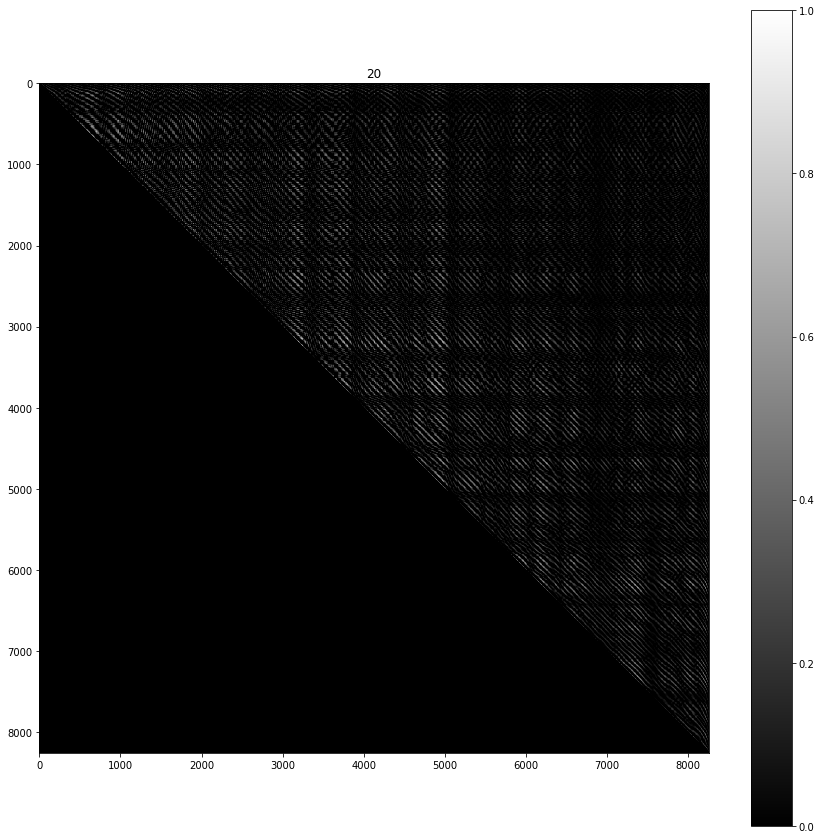

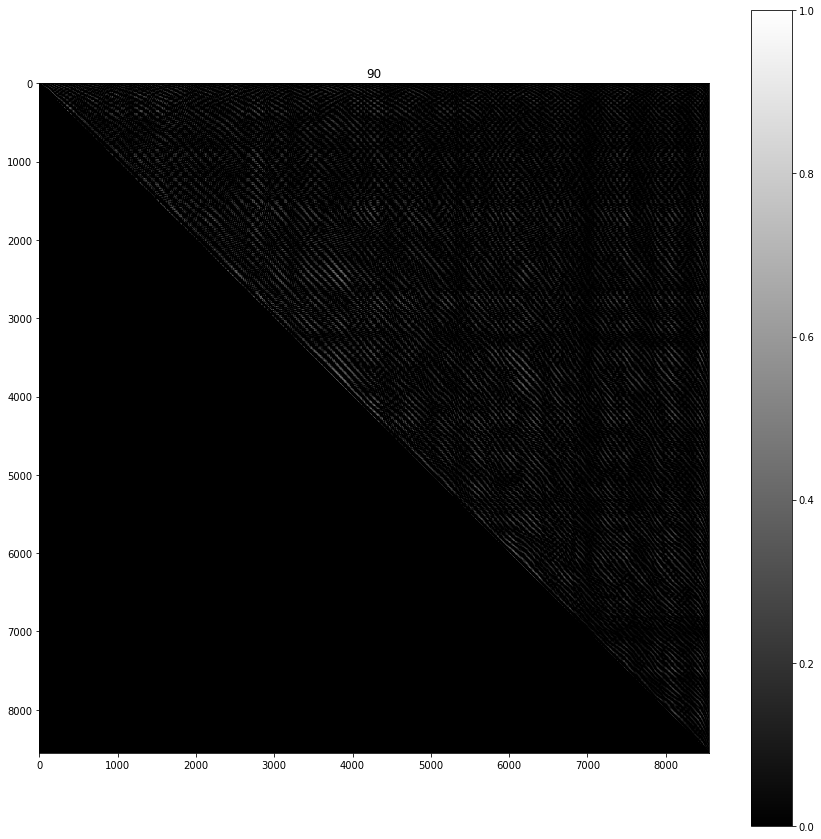

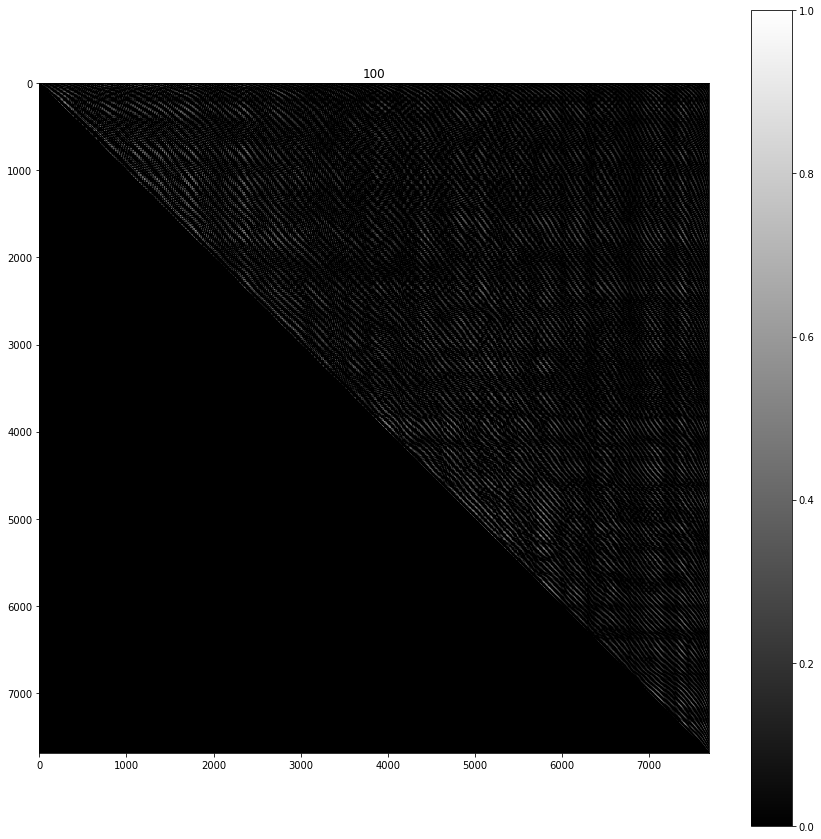

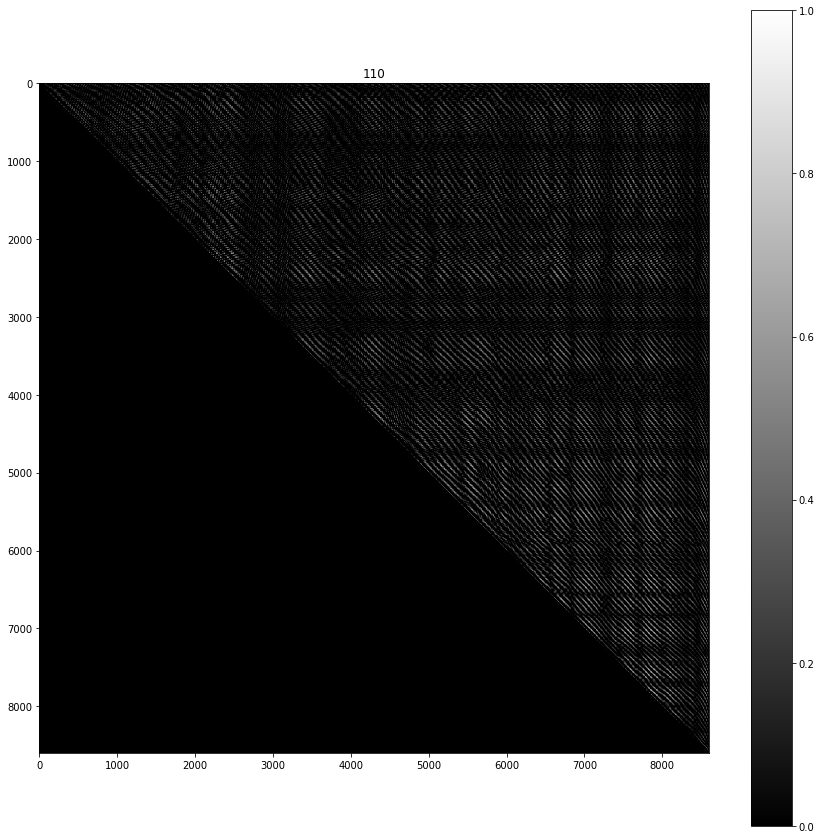

In [6]:
PIDs = [0, 10, 20, 90, 100, 110]
for i, pid in enumerate(PIDs):
    xcorr_map = np.load(f'xcoor_maps/{pid}.npy')
    plt.figure(pid, figsize=(15, 15))
    plt.imshow(xcorr_map, cmap='gray', vmin=0, vmax=1)
    plt.colorbar()
    plt.title(pid)